In [8]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

import joblib
from joblib import Parallel, delayed

# TERC Data
one_hot, labels, _ = joblib.load("/Users/MacUser/Desktop/CS542/Final_Project/labels.joblib")
y = np.argmax(one_hot, axis=1)
y_array = np.array(one_hot)
#representation_files = ['pca_representation.joblib', "inception_representations.joblib", "resnet_representations.joblib"]

X = joblib.load("/Users/MacUser/Desktop/CS542/Final_Project/resnet_preprocessed.joblib")

In [10]:
label_name = (sorted(set(labels)))

In [11]:
Y = y_array #already binarize

# Split into training and test
#X_train, X_test, y_train_array, y_test_array =  train_test_split(X, Y, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

# Our model
model = load_model("/Users/MacUser/Desktop/CS542/Final_Project/resnet_single_model-final.hdf5")
y_score = model.predict(np.array(X_test)) #y_predict same as y_score


In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
n_classes = Y.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

print(Y_test.shape)
print(y_score.shape)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

(241, 11)
(241, 11)
Average precision score, micro-averaged over all classes: 0.63


In [18]:
print(average_precision)

{0: 0.93994207348078962, 1: 0.99999999999999978, 2: 0.41854518247062183, 3: 0.70552446589088702, 4: 1.0000000000000002, 5: 0.99539406905183692, 6: 0.6549058873986664, 7: 0.49907892380173097, 8: 0.79560854541323234, 9: 0.90908446543213928, 10: 0.060864426309315406, 'micro': 0.6303933095546933}


In [14]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                  color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [ ]:
def plot_curve(precision, recall, average_precision, representation_name, algos, prefix):
    print(len(precision), len(recall), len(average_precision), len(representation_name), len(algos), prefix)

    ## plotting code (once per representation)
    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('$f_1={0:0.1f}$'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('$iso-f_1 curves$')


    # plot each algorithm
    for i, (color, algo) in enumerate(zip(colors, algos)):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for {0} (area = {1:0.2f})'
                   ''.format(algo, average_precision[i]))


    # fig = plt.gcf()
    #fig.subplots_adjust(right=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.title("Precision-Recall curves for the fine-tuned InceptionNet \nand some other approaches based on (non-fine-tuned) InceptionNet representations")
    plt.title("Precision-Recall curves for some approaches based on {0} representations".format(representation_name))
    lgd = plt.legend(lines, labels, loc='upper left', prop=dict(size=14), bbox_to_anchor=(1.02, 1))

    plt.savefig(os.path.join(prefix, '{0}algos.png'.format(representation_name)), bbox_extra_artists=(lgd,), bbox_inches="tight")



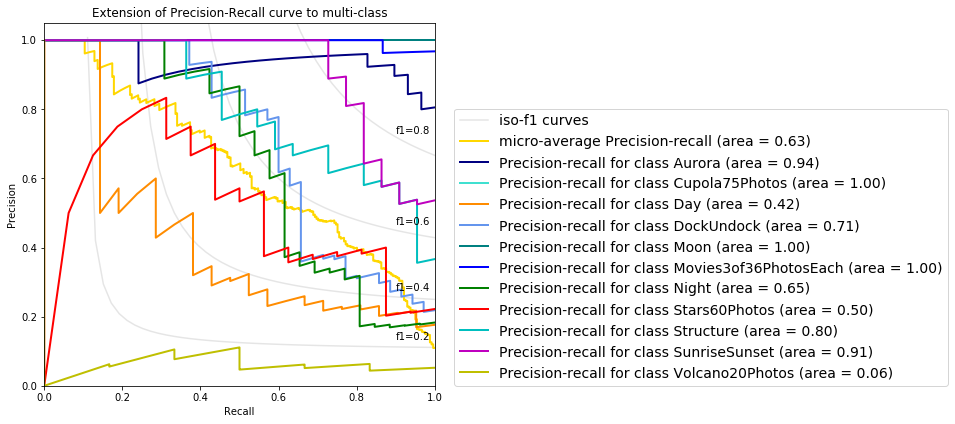

In [37]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'b', 'g', 'r', 'c', 'm', 'y', 'y', 'g'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(label_name[i], average_precision[i]))
# Do this .format(label[i])
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(1.05, 0), prop=dict(size=14))


plt.savefig('/Users/MacUser/Desktop/CS542/Final_Project/label.png'.format(''), bbox_inches="tight")

plt.show()